In [52]:
source_folder = '../Data/Processed/'
destination_folder = '../Data/Processed/LSTM'

In [53]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator

# Models

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [54]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [119]:
# Fields

id_field = Field(sequential=False, use_vocab=False, batch_first=True,dtype=torch.int)
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('target', label_field),('text', text_field),('id', id_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=3)

In [7]:
"""
source_folder = '../Data/Processed'
raw_data_path = '../Data/train.csv'
destination_folder = '../Data/Processed'

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
id_field = Field(sequential=False, use_vocab=False, batch_first=True,dtype=torch.int)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('target', label_field),('text', text_field),('id', id_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
"""

"\nsource_folder = '../Data/Processed'\nraw_data_path = '../Data/train.csv'\ndestination_folder = '../Data/Processed'\n\ntokenizer = BertTokenizer.from_pretrained('bert-base-uncased')\n\n# Model parameter\nMAX_SEQ_LEN = 128\nPAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)\nUNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)\n\n# Fields\n\nlabel_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)\nid_field = Field(sequential=False, use_vocab=False, batch_first=True,dtype=torch.int)\ntext_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,\n                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)\nfields = [('target', label_field),('text', text_field),('id', id_field)]\n\n# TabularDataset\n\ntrain, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',\n                                          

In [19]:
class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

In [15]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [21]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, (text, text_len), ids), _ in train_loader:           
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                    for (labels, (text, text_len), ids),_ in valid_loader:
                        labels = labels.to(device)
                        text = text.to(device)
                        text_len = text_len.to(device)
                        output = model(text, text_len)
                        loss = criterion(output, labels)
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [22]:
model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, num_epochs=10)

Epoch [1/10], Step [83/1670], Train Loss: 0.6558, Valid Loss: 0.6100
Model saved to ==> ../Data/Processed/LSTM/model.pt
Model saved to ==> ../Data/Processed/LSTM/metrics.pt
Epoch [1/10], Step [166/1670], Train Loss: 0.6025, Valid Loss: 0.5524
Model saved to ==> ../Data/Processed/LSTM/model.pt
Model saved to ==> ../Data/Processed/LSTM/metrics.pt
Epoch [2/10], Step [249/1670], Train Loss: 0.4792, Valid Loss: 0.5193
Model saved to ==> ../Data/Processed/LSTM/model.pt
Model saved to ==> ../Data/Processed/LSTM/metrics.pt
Epoch [2/10], Step [332/1670], Train Loss: 0.4560, Valid Loss: 0.5059
Model saved to ==> ../Data/Processed/LSTM/model.pt
Model saved to ==> ../Data/Processed/LSTM/metrics.pt
Epoch [3/10], Step [415/1670], Train Loss: 0.3464, Valid Loss: 0.5168
Epoch [3/10], Step [498/1670], Train Loss: 0.3131, Valid Loss: 0.5696
Epoch [4/10], Step [581/1670], Train Loss: 0.2395, Valid Loss: 0.5893
Epoch [4/10], Step [664/1670], Train Loss: 0.1938, Valid Loss: 0.7135
Epoch [5/10], Step [747/1

Model loaded from <== ../Data/Processed/LSTM/metrics.pt


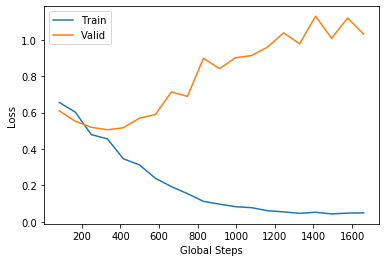

In [23]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [120]:
from datetime import datetime
def evaluate_to_df(model, test_loader, threshold=0.5):
    y_pred = []
    y_id = []

    model.eval()
    with torch.no_grad():
        for ((text, text_len),idn), _ in test_loader:     
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_id.extend(idn.tolist())
    submission_df = pd.DataFrame()
    submission_df['prediction'] = y_pred
    submission_df['id'] = y_id
    return submission_df

In [93]:
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)

Model loaded from <== ../Data/Processed/LSTM/model.pt


0.5058723820580376

In [94]:
test_fields =[('text', text_field),('id', id_field)]
test_data = TabularDataset(path='../Data/Processed/test.csv', fields=test_fields, format='CSV', skip_header=True)

In [95]:
from torchtext.data import Iterator

test_iter = BucketIterator(test_data, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=False, sort_within_batch=True)

In [121]:
submission_df = evaluate_to_df(best_model, test_iter)

In [123]:
submission_df = submission_df[submission_df['id'] != -1]
submission_df = submission_df[['id','prediction']]
submission_df.columns = ['id', 'target']

In [125]:
submission_df = submission_df.sort_values('id')
submission_df.head()

,id,target
1578,0,1
3161,2,1
2185,3,1
1847,9,1
1261,11,1


In [ ]:
submission_df.to_csv